In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

In [2]:
# import the modules
import gymnasium as gym

# import the necessary packages for torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
env = gym.make("CarRacing-v3")


obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
env.render()
env.close()

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/box2d/car_racing.py:593: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CarRacing-v3", render_mode="rgb_array")
  gym.logger.warn(


In [3]:
AE_loss = []
VQ_VAE_loss = []

In [17]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize = T.Compose([T.ToTensor(), T.Resize((64, 64))])

class Encoder(nn.Module):
    def __init__(self, channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)

        dummy = torch.zeros(1, channels, 64, 64)
        x = self.conv3(self.conv2(self.conv1(dummy)))
        self.shape_before_flattening = x.shape[1:]
        self.fc = nn.Linear(np.prod(self.shape_before_flattening), embedding_dim)

    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, shape, channels, embedding_dim):
        super(Decoder, self).__init__()
        self.shape = shape
        self.fc = nn.Linear(embedding_dim, np.prod(shape))
        self.deconv1 = nn.ConvTranspose2d(shape[0], 64, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(32, channels, 4, 2, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), *self.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        return torch.sigmoid(self.deconv3(x))

class ForwardModel(nn.Module):
    def __init__(self, encoder, decoder, action_dim, embedding_dim):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.action_net = nn.Sequential(
            nn.Linear(action_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
        self.fc = nn.Linear(embedding_dim * 2, embedding_dim)

    def forward(self, obs, action):
        obs_emb = self.encoder(obs)
        act_emb = self.action_net(action)
        fused = F.relu(self.fc(torch.cat([obs_emb, act_emb], dim=1)))
        return self.decoder(fused)

def collect_data(env, steps):
    obs_arr, act_arr, next_arr = [], [], []
    obs, _ = env.reset()
    for _ in tqdm(range(steps), desc="Collecting data"):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        obs_arr.append(resize(obs).numpy() * 255)
        next_arr.append(resize(next_obs).numpy() * 255)
        act_arr.append(action)
        obs = env.reset()[0] if done else next_obs

    return (
        torch.tensor(np.array(obs_arr), dtype=torch.float32).to(device),
        torch.tensor(np.array(act_arr), dtype=torch.float32).to(device),
        torch.tensor(np.array(next_arr), dtype=torch.float32).to(device),
    )

def train_model(model, obs, actions, next_obs, epochs, batch_size):
    dataset = DataLoader(TensorDataset(obs, actions, next_obs), batch_size=batch_size, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for o, a, n in dataset:
            o, n = o / 255.0, n / 255.0
            opt.zero_grad()
            with autocast():
                loss = loss_fn(model(o, a), n)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()
        avg = total_loss / len(dataset)
        losses.append(avg)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg:.4f}")
    return np.array(losses).mean()

# Main Training Loop
env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
obs_sample = resize(env.reset(seed=42)[0]).numpy() * 255
C, H, W = obs_sample.shape
embedding_dim = 32
action_dim = env.action_space.shape[0]

encoder = Encoder(C, embedding_dim).to(device)
decoder = Decoder(encoder.shape_before_flattening, C, embedding_dim).to(device)
model = ForwardModel(encoder, decoder, action_dim, embedding_dim).to(device)

AE_loss = []
k = 30
collect_step = 2500
train_epochs = 10
batch_size = 8

for cycle in range(k):
    print(f"\n--- Cycle {cycle+1}/{k} ---")
    obs_tensor, action_tensor, next_tensor = collect_data(env, collect_step)
    losses = train_model(model, obs_tensor, action_tensor, next_tensor, train_epochs, batch_size)
    AE_loss.append(losses)



--- Cycle 1/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0091


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0051


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0051


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0050


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0050


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0050


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0050


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0031


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0017


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0010

--- Cycle 2/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0011


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0009


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0007


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0006


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0006


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0004

--- Cycle 3/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0003

--- Cycle 4/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0005


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0002

--- Cycle 5/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 6/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0007


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0002

--- Cycle 7/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 8/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 9/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 10/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0002

--- Cycle 11/30 ---


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 12/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0003


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 13/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0004


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 14/30 ---


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 15/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 16/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 17/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 18/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 19/30 ---


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 20/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 21/30 ---


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 22/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 23/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 24/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 25/30 ---


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 26/30 ---


/tmp/ipython-input-17-2987239401.py:91: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler, losses, loss_fn = GradScaler(), [], nn.MSELoss()
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10, Loss: 0.0002


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/10, Loss: 0.0001


/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-17-2987239401.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/10, Loss: 0.0001

--- Cycle 27/30 ---


KeyboardInterrupt: 

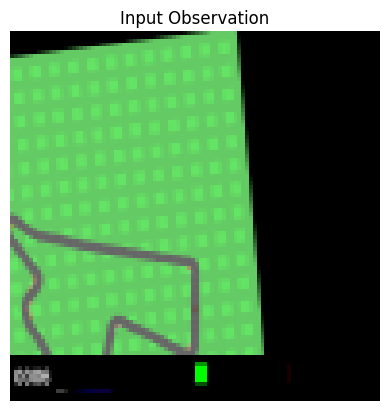

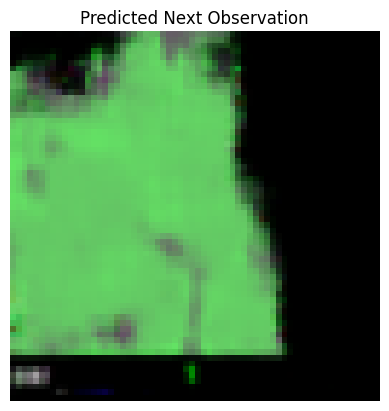

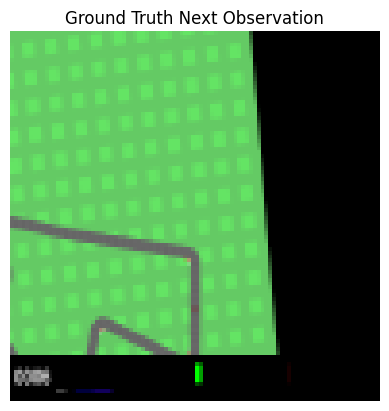

In [19]:
# ---------- Inference with k random steps ----------
r_steps = 2  # number of random steps before evaluating
def show_rgb_image(image_tensor,title):
    # Ensure it's detached from computation graph, and in CPU memory
    if isinstance(image_tensor, torch.Tensor):
        image = image_tensor.detach().cpu().numpy()

    # If shape is [C, H, W], transpose to [H, W, C]
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))

    # If pixel values are in [0, 255], convert to uint8
    if image.max() > 1.0:
        image = np.clip(image, 0, 255).astype(np.uint8)
    else:
        # Scale to [0,255] just in case
        image = (image * 255).astype(np.uint8)

    # Plot using matplotlib
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()
with torch.no_grad():
    obs, _ = env.reset(seed=np.random.randint(10000))

    for _ in range(r_steps):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if done:
            obs, _ = env.reset(seed=np.random.randint(10000))
        else:
            obs = next_obs

    # Final sampled action and
    original_obs = torch.tensor(obs) / 255.0
    obs = resize(obs).numpy()
    action = env.action_space.sample()

    obs_tensor_input = torch.tensor(obs, dtype=torch.float).unsqueeze(0).to(device) / 255.0
    action_tensor_input = torch.tensor(action, dtype=torch.float).unsqueeze(0).to(device)

    # Step once more to get the ground-truth next observation
    next_obs, _, _, _, _ = env.step(action)
    gt_next_tensor = torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float).to(device) / 255.0

    # Model prediction
    pred_next = model(obs_tensor_input, action_tensor_input)[0].clamp(0.0, 1.0)

    # Visualization
    show_rgb_image(original_obs, title="Input Observation")
    show_rgb_image(pred_next, title="Predicted Next Observation")
    show_rgb_image(gt_next_tensor, title="Ground Truth Next Observation")


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.code_book_size = code_book_size
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(code_book_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1/code_book_size, 1/code_book_size)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # BSxCxHxW --> BSxHxWxC
        input_shape = inputs.shape

        flat_input = inputs.view(-1, 1, self.embedding_dim)  # BSxHxWxC --> BS*H*Wx1xC

        # Calculate the distance between each embedding and each codebook vector
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)  # BS*H*WxN

        # Find the closest codebook vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # BS*H*Wx1

        # Select that codebook vector
        quantized = self.embedding(encoding_indices).view(input_shape)

        # Create loss that pulls encoder embeddings and codebook vector selected
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Reconstruct quantized representation using the encoder embeddings to allow for
        # backpropagation of gradients into encoder
        if self.training:
            quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)


class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.norm1 = nn.GroupNorm(8, channels)
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.norm2 = nn.GroupNorm(8, channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        skip = x

        x = F.elu(self.norm1(x))
        x = F.elu(self.norm2(self.conv1(x)))
        x = self.conv2(x) + skip
        return x


# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn2 = nn.GroupNorm(8, channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x = F.elu(self.bn1(x))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.GroupNorm(8, channels_in)

        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.GroupNorm(8, channels_in)

        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)

        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = self.up_nn(F.elu(self.bn1(x_in)))

        x_skip = self.conv3(x)

        x = F.elu(self.bn2(self.conv1(x)))
        return self.conv2(x) + x_skip


# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)

        self.conv_block1 = DownBlock(ch, ch * 2)
        self.conv_block2 = DownBlock(ch * 2, ch * 4)

        # Instead of flattening (and then having to unflatten) out our feature map and
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map
        # (in practice it's the same thing)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_3 = ResBlock(ch * 4)

        self.conv_out = nn.Conv2d(4 * ch, latent_channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv_1(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = F.elu(self.res_block_3(x))

        return self.conv_out(x)


class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, latent_channels = 32):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(latent_channels, 4 * ch, 3, 1, 1)
        self.res_block_1 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)
        self.res_block_2 = ResBlock(ch * 4)

        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res_block_1(x)
        x = self.res_block_2(x)
        x = self.res_block_2(x)

        x = self.conv_block1(x)
        x = self.conv_block2(x)

        return torch.tanh(self.conv_out(x))

class VQVAE(nn.Module):
    def __init__(self, channel_in, ch=16, latent_channels=32, code_book_size=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

        self.vq = VectorQuantizer(code_book_size=code_book_size,
                                  embedding_dim=latent_channels,
                                  commitment_cost=commitment_cost)

        self.decoder = Decoder(channels=channel_in, ch=ch, latent_channels=latent_channels)

    def encode(self, x):
        encoding = self.encoder(x)
        vq_loss, quantized, encoding_indices = self.vq(encoding)
        return vq_loss, quantized, encoding_indices

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        vq_loss, quantized, encoding_indices = self.encode(x)
        recon = self.decode(quantized)

        return recon, vq_loss, quantized


# VQ VAE

In [21]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# ----- VQ-VAE Components -----
class VectorQuantizer(nn.Module):
    def __init__(self, code_book_size, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding = nn.Embedding(code_book_size, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / code_book_size, 1 / code_book_size)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        flat_input = inputs.view(-1, 1, inputs.shape[-1])
        distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2).mean(2)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized = self.embedding(encoding_indices).view(input_shape)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        if self.training:
            quantized = inputs + (quantized - inputs).detach()
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.reshape(input_shape[0], -1)

class Encoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, ch, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(ch, ch * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(ch * 2, latent_channels, 3, 1, 1)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, channels, ch=32, latent_channels=32):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, ch * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(ch * 2, ch, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(ch, channels, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class ActionConditionedVQVAE(nn.Module):
    def __init__(self, channel_in, action_dim, ch=16, latent_channels=32, code_book_size=64, commitment_cost=0.25):
        super().__init__()
        self.encoder = Encoder(channel_in, ch, latent_channels)
        self.vq = VectorQuantizer(code_book_size, latent_channels, commitment_cost)
        self.action_net = nn.Sequential(
            nn.Linear(action_dim, latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels)
        )
        self.fusion = nn.Conv2d(latent_channels * 2, latent_channels, kernel_size=1)
        self.decoder = Decoder(channel_in, ch, latent_channels)

    def forward(self, obs, action):
        z = self.encoder(obs)
        vq_loss, quantized, _ = self.vq(z)
        action_embed = self.action_net(action).unsqueeze(2).unsqueeze(3).expand_as(quantized)
        fused = torch.cat([quantized, action_embed], dim=1)
        fused = self.fusion(fused)
        recon = self.decoder(fused)
        return recon, vq_loss

# ----- Utility -----
def show_rgb_image(image_tensor, title=""):
    image = image_tensor.detach().cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ----- Setup -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs_sample = env.reset(seed=42)[0]
C, H, W = obs_sample.shape[2], obs_sample.shape[0], obs_sample.shape[1]
action_dim = env.action_space.shape[0]

model = ActionConditionedVQVAE(channel_in=C, action_dim=action_dim, ch=16, latent_channels=embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

# ----- Data Collection -----
def collect_data(env, steps):
    obs_arr, act_arr, next_arr = [], [], []
    obs, _ = env.reset()
    for _ in tqdm(range(steps), desc="Collecting data"):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        obs_arr.append(torch.tensor(obs.transpose(2, 0, 1), dtype=torch.float))
        act_arr.append(torch.tensor(action, dtype=torch.float))
        next_arr.append(torch.tensor(next_obs.transpose(2, 0, 1), dtype=torch.float))
        if done:
            obs, _ = env.reset()
        else:
            obs = next_obs
    return torch.stack(obs_arr) / 255.0, torch.stack(act_arr), torch.stack(next_arr) / 255.0

# ----- Training -----
def train_model(model, optimizer, obs_tensor, action_tensor, next_tensor, epochs, batch_size):
    dataset = DataLoader(TensorDataset(obs_tensor, action_tensor, next_tensor), batch_size=batch_size, shuffle=True)
    model.train()
    all_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for obs_batch, act_batch, next_batch in dataset:
            obs_batch, act_batch, next_batch = obs_batch.to(device), act_batch.to(device), next_batch.to(device)
            pred_next, vq_loss = model(obs_batch, act_batch)
            loss = mse_loss(pred_next, next_batch) + vq_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        all_losses.append(avg_loss)

    return np.mean(all_losses)

# ----- Main Training Loop -----
VQ_VAE_loss = []

for cycle in range(k):
    print(f"\n--- Cycle {cycle+1}/{k} ---")
    obs_tensor, act_tensor, next_tensor = collect_data(env, collect_step)
    cycle_loss = train_model(model, optimizer, obs_tensor, act_tensor, next_tensor, train_epochs, batch_size)
    VQ_VAE_loss.append(cycle_loss)

# ----- Inference -----
model.eval()
with torch.no_grad():
    sample_obs = obs_tensor[0].unsqueeze(0).to(device)
    sample_action = act_tensor[0].unsqueeze(0).to(device)
    sample_next = next_tensor[0]
    pred_next, _ = model(sample_obs, sample_action)
    show_rgb_image(sample_obs[0], title="Input Observation")
    show_rgb_image(pred_next[0], title="Predicted Next Observation")
    show_rgb_image(sample_next, title="Ground Truth Next Observation")



--- Cycle 1/30 ---


Epoch 1, Loss: 0.0208
Epoch 2, Loss: 0.0019
Epoch 3, Loss: 0.0016
Epoch 4, Loss: 0.0014
Epoch 5, Loss: 0.0013
Epoch 6, Loss: 0.0012
Epoch 7, Loss: 0.0011
Epoch 8, Loss: 0.0011
Epoch 9, Loss: 0.0010
Epoch 10, Loss: 0.0010

--- Cycle 2/30 ---


Epoch 1, Loss: 0.0011
Epoch 2, Loss: 0.0010
Epoch 3, Loss: 0.0009
Epoch 4, Loss: 0.0008
Epoch 5, Loss: 0.0008
Epoch 6, Loss: 0.0007
Epoch 7, Loss: 0.0007
Epoch 8, Loss: 0.0007
Epoch 9, Loss: 0.0007
Epoch 10, Loss: 0.0006

--- Cycle 3/30 ---


Epoch 1, Loss: 0.0007
Epoch 2, Loss: 0.0007
Epoch 3, Loss: 0.0006
Epoch 4, Loss: 0.0006
Epoch 5, Loss: 0.0006
Epoch 6, Loss: 0.0006
Epoch 7, Loss: 0.0005
Epoch 8, Loss: 0.0005
Epoch 9, Loss: 0.0005
Epoch 10, Loss: 0.0006

--- Cycle 4/30 ---


Epoch 1, Loss: 0.0006
Epoch 2, Loss: 0.0005
Epoch 3, Loss: 0.0005
Epoch 4, Loss: 0.0005
Epoch 5, Loss: 0.0005
Epoch 6, Loss: 0.0005
Epoch 7, Loss: 0.0005
Epoch 8, Loss: 0.0005
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0004

--- Cycle 5/30 ---


Epoch 1, Loss: 0.0005
Epoch 2, Loss: 0.0005
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0004
Epoch 5, Loss: 0.0005
Epoch 6, Loss: 0.0005
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0004

--- Cycle 6/30 ---


Epoch 1, Loss: 0.0005
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0004
Epoch 5, Loss: 0.0004
Epoch 6, Loss: 0.0004
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0004
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0004

--- Cycle 7/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0004
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 8/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0004
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 9/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 10/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 11/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 12/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 13/30 ---


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0003

--- Cycle 14/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 15/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0003
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 16/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 17/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0003
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 18/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 19/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0003
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 20/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0003
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 21/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 22/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0003

--- Cycle 23/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 24/30 ---


Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0003
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 25/30 ---


Epoch 1, Loss: 0.0002
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 26/30 ---


Epoch 1, Loss: 0.0002
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0002
Epoch 4, Loss: 0.0002
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0002
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0002
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0002

--- Cycle 27/30 ---


KeyboardInterrupt: 

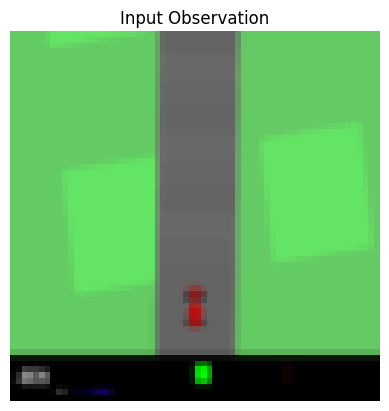

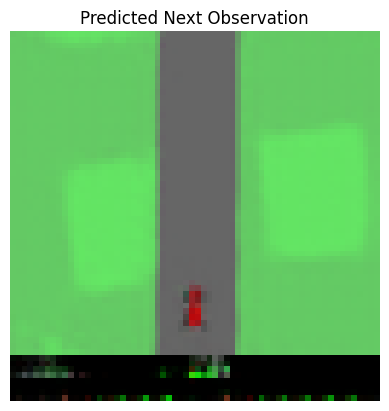

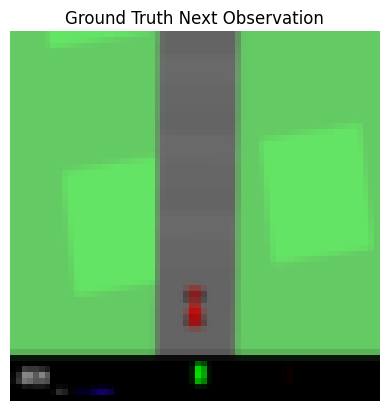

In [22]:
import torchvision.transforms as T

# Resize transform (to match training input size, e.g., 64x64 if needed)
resize = T.Compose([
    T.ToPILImage(),
    T.Resize((64, 64)),  # <-- make sure this matches the model input size
    T.ToTensor()
])

# ---------- Inference with k random steps ----------
r_steps = 250  # number of random steps before evaluating

with torch.no_grad():
    obs, _ = env.reset(seed=np.random.randint(10000))

    for _ in range(r_steps):
        action = env.action_space.sample()
        next_obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if done:
            obs, _ = env.reset(seed=np.random.randint(10000))
        else:
            obs = next_obs

    # Save the last observation before action
    original_obs = resize(torch.tensor(obs, dtype=torch.uint8).permute(2, 0, 1)).to(torch.float32)
    action = env.action_space.sample()

    obs_tensor_input = original_obs.unsqueeze(0).to(device)
    action_tensor_input = torch.tensor(action, dtype=torch.float).unsqueeze(0).to(device)

    # Step once more to get the ground-truth next observation
    next_obs, _, _, _, _ = env.step(action)
    gt_next_tensor = resize(torch.tensor(next_obs, dtype=torch.uint8).permute(2, 0, 1)).to(torch.float32) / 1.0

    # Model prediction
    pred_next = model(obs_tensor_input, action_tensor_input)[0].clamp(0.0, 1.0).squeeze()

    # Visualization
    show_rgb_image(original_obs, title="Input Observation")
    show_rgb_image(pred_next, title="Predicted Next Observation")
    show_rgb_image(gt_next_tensor, title="Ground Truth Next Observation")


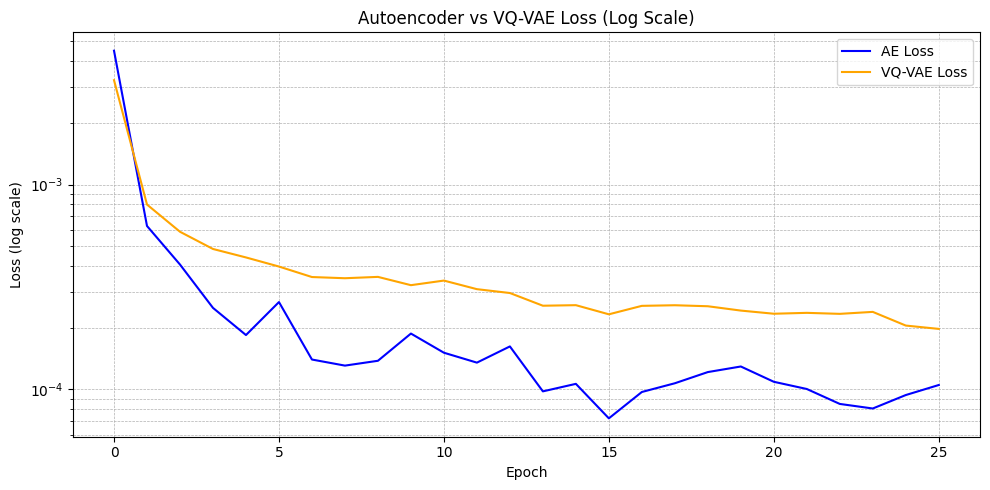

In [23]:
import matplotlib.pyplot as plt

# Example: AE_loss = [...], VQ_VAE_loss = [...]

plt.figure(figsize=(10, 5))
plt.plot(AE_loss, label="AE Loss", color="blue")
plt.plot(VQ_VAE_loss, label="VQ-VAE Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Autoencoder vs VQ-VAE Loss (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()
